<a href="https://colab.research.google.com/github/masdatascience/TFM-AI/blob/master/AI_TFM_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install turicreate
!pip install lifetimes
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import sys
sys.path.append("..")
## Algoritmos de ML
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import tree
import graphviz 
from sklearn import metrics

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [2]:
url = 'https://github.com/masdatascience/TFM-AI/blob/master/transacciones.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url)
datos_facturacion = pd.read_excel(datos_modelo_completo, sheet_name='transacciones')
# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
#datos_facturacion = datos_facturacion.dropna(subset=['customer_id'])
#datos_facturacion = datos_facturacion.dropna(subset=['product_id'])
# Se elimina posibles chargeback que se presenten
url1 = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_modelo_completo = pd.ExcelFile(url1)
#datos_facturacion = datos_facturacion.loc[datos_facturacion['total_value'] > 0]
datos_producto = pd.read_excel(datos_modelo_completo, sheet_name='product')
datos_clientes = pd.read_excel(datos_modelo_completo, sheet_name='customer')
print("datos productos: "+str(datos_producto.shape))
print("datos clientes: "+str(datos_clientes.shape))
print("datos facturación: "+str(datos_facturacion.shape))
# se visualiza el número de comrpas que tiene un cliente
datos_clientes.groupby('customer_id').size().value_counts()
datos_facturacion.groupby('customer_id').size().value_counts()
  

datos productos: (32951, 10)
datos clientes: (96352, 4)
datos facturación: (100010, 11)


1     91370
2      3643
3       327
4        55
5        14
6         6
7         3
16        1
10        1
dtype: int64

3.1 MARCAJE CHURN 


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/lifetimes/generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


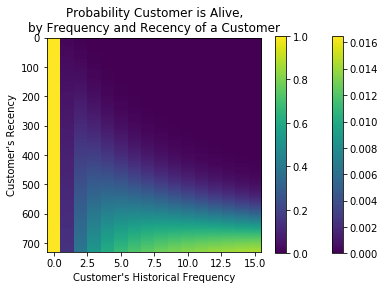

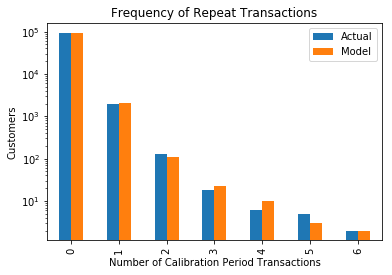

In [3]:
datos_facturacion['date'] = pd.to_datetime(datos_facturacion['order_purchase_timestamp']).dt.date
datos_facturacion = datos_facturacion.drop('order_purchase_timestamp',axis=1)
# se realiza un subconjunto de columnas con los cuales se analizará el comportamiento de compra
transaction_data = datos_facturacion[['customer_id','date','price']]
# se crea el modelo RFM
summary = summary_data_from_transaction_data(transaction_data,'customer_id','date',monetary_value_col='price',)
t=1
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
plot_frequency_recency_matrix(bgf);
plot_probability_alive_matrix(bgf)
plot_period_transactions(bgf).set_yscale('log');
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


1    95844
2      248
3        4
dtype: int64

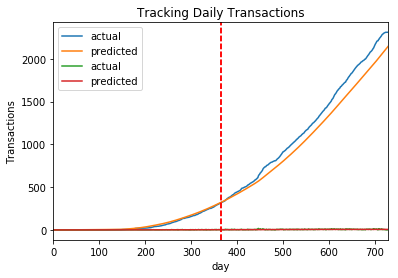

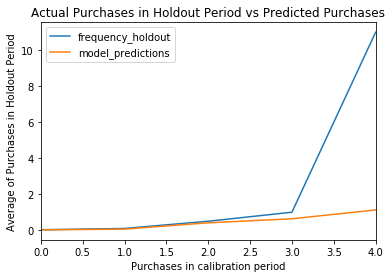

In [4]:
summary_cal_holdout = calibration_and_holdout_data(datos_facturacion, 'customer_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_incremental_transactions(bgf, datos_facturacion, 'date', 'customer_id', 730, 365);
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);
datos_clientes.groupby('customer_id').size().value_counts()



churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

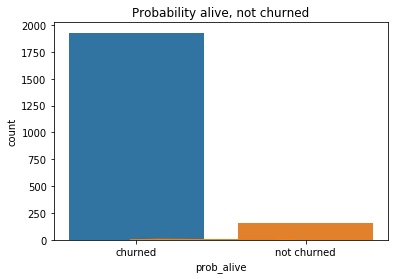

In [5]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()


3.2 Churn prediction


In [6]:
print(summary.median())
df['is_churn'] = np.where( (df['frequency']<1) & (df['T']>400) & (df['recency']<1) & (df['recency']<0.000044), 1, 0) 
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
prueba_clientes['is_churn'].fillna(0, inplace=True)
prueba_clientes['seller_id'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()

frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


0.17545294915795354

In [0]:
def labelDatase(dataset):

  le = preprocessing.LabelEncoder()

  for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass

  return dataset
  

In [8]:
print(summary.median())
df['is_churn'] = np.where( (df['frequency']<1) & (df['T']>400) & (df['recency']<1) & (df['recency']<0.000044), 1, 0) 
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 

prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
prueba_clientes['is_churn'].fillna(0, inplace=True)
prueba_clientes['seller_id'].fillna(0, inplace=True)
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()


frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
is_churn                 0.000000
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


0.17545294915795354

In [9]:
enconder = LabelEncoder()


dataset =  prueba_clientes.drop(['customer_id','customer_city','seller_id'], axis=1)
ds_customer_city = pd.get_dummies(prueba_clientes.customer_city).iloc[:,1:]
#ds_seller_id = pd.get_dummies(prueba_clientes.seller_id.astype('category').cat.codes).iloc[:,1:]
ds_seller_id = pd.get_dummies(prueba_clientes.seller_id).iloc[:,1:]
customer = pd.concat([dataset,ds_customer_city,ds_seller_id], axis=1)
#customer['customer_id']= enconder.fit_transform(customer["customer_id"])
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
print(customer.shape)
customer.head()

(100232, 7216)


,customer_state,customer_zip_code_prefix,is_churn,abadiania,abaete,abaetetuba,abaiara,abaira,abare,abatia,abdon batista,abelardo luz,abrantes,abre campo,abreu e lima,acaiaca,acailandia,acajutiba,acarau,acari,acegua,acopiara,acreuna,acu,acucena,adamantina,adhemar de barros,adolfo,adrianopolis,adustina,afogados da ingazeira,afonso claudio,afranio,agisse,agrestina,agrolandia,agronomica,agua boa,agua branca,agua clara,...,fd386aa7bed2af3c7035c65506c9b4a3,fd435faa3c0422b60440ea3480d0e77c,fdaaf5bfda82b7b80535610c831b8d09,fdb9095204a334cd8872252ffec6f2db,fde0cc9ea29c8ccfc0a2c22256a58c71,fdf736c18c589ed030e058312203e1b2,fe19dce63ae80346207c6c55713d1023,fe1b067411b8c5066e962aa146ccee03,fe1bbc5feda5c8979a8a1b3b2512d5a6,fe2032dab1a61af8794248c8196565c9,fe26f3ecb51a15e6d8335cd92da42562,fe49ee029e61e789a1f3a5525f57ba8d,fe4cd9461203cee790d36792420b310f,fe701d88b67eaca109dffd464d1be9f9,fe8055980a4ff7f64ed889c2b5926929,fe87f472055fbcf1d7e691c00b1560dc,fe9d9cf8631285d5982c6e2cf27fb114,feb793c88d836c3a75efa4b5a3465d70,febab0275244b9a49a623f0bd613ca2f,fec6275253471ace26d209bbaa64cd0f,fec6912baad85d41729669edd6b4d3b8,fec8cd45395b3cb0c2b173d7739706a1,fedaedd3ca31d56ab33e92035e4b361c,fedf2c1386e137f296b3bbf3b635e69d,ff063b022a9a0aab91bad2c9088760b7,ff1e15b778c700abdd4d239b81ac466d,ff1fb4c404b2efe68b03350a8dc24122,ff314fa6033cc68ec451c47aee2d6ba4,ff4e2d38692ce827b1a4f4b8196e680d,ff4ea69c2a729e83e63c7579e4ef8170,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffcfefa19b08742c5d315f2791395ee5,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89,ffff564a4f9085cd26170f4732393726
0,25,7787,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25,6053,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,23,88115,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13,66812,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,18040,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import graphviz 

# Algoritmo Random Forest
def randomForest():
  print("inicia Random Forest")
  rfc_object = rfc(n_estimators=200, random_state=0)
  rfc_object.fit(train_features, train_labels)
  predicted_labels = rfc_object.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))

  # Regresión lineal
def regresionLineal():
  print("inicia Regresión lineal")
  # Algoritmo
  lr_object = LogisticRegression()
  lr_object.fit(train_features, train_labels)
  predicted_labels = lr_object.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))
  
  
# arbol de decision
def arbolDecision():
  print("inicia Arboles de decisión")
  # Create each decision tree (pruned and unpruned)
  decisionTree_unpruned = tree.DecisionTreeClassifier()
  decisionTree = tree.DecisionTreeClassifier(max_depth = 4)
  # Fit each tree to our training data
  decisionTree_unpruned = decisionTree_unpruned.fit(X=train_features, y=train_labels)
  decisionTree = decisionTree.fit(X=train_features, y=train_labels)
  # Generate PDF visual of decision tree
  churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                           feature_names = list(train_features.columns.values),  
                           class_names = ['No churn', 'Churn'],
                           filled=True, rounded=True,  
                           special_characters=True)  
  graph = graphviz.Source(churnTree)
  graph.render('decision_tree.gv', view=True)
  predicted_labels = decisionTree.predict(test_features)
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))
  

#GradientBoostingClassifier
def gradientBoost():
  print("inicia Gradient Boosting Classifier")
  #Create Gradient Boosting Classifier
  gb = GradientBoostingClassifier()
  #Train the model using the training sets
  gb.fit(train_features, train_labels)
  #Predict the response for test dataset
  predicted_labels = gb.predict(test_features)
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))
  
    # SVM  
def SVM():
  # Algoritmo
  print("inicia Support Vector Machine")
  svc_object = svc(kernel='rbf', degree=8)
  svc_object.fit(train_features, train_labels)
  predicted_labels = svc_object.predict(test_features) 
  # se verifican resultados
  print(classification_report(test_labels, predicted_labels))
  print(confusion_matrix(test_labels, predicted_labels))
  print(accuracy_score(test_labels, predicted_labels))

# Deep Learning
def redesNeuronales():
  print("Inicia Deep Learning")
  # Se genera el modelo 
  modelo = Sequential()
  #Se define un monitor de parada temprana para que el modelo deje de entrenar cuando ya no mejore
  early_stopping_monitor = EarlyStopping(patience=3)
  #Se obtienen las columnas de entrenamiento
  scale = StandardScaler()
  X_dataset = scale.fit_transform(features)
  Y_dataset =labels.values 
  n_cols = X_dataset.shape[1]
  #Se agregan las capas, aumentar el número de nodos en cada capa aumenta la capacidad del modelo pero por Collab lo dejare en esa cantidad
  # La función de activación que utilizaremos es ReLU o activación lineal rectificada. 
  # Aunque se trata de dos piezas lineales, se ha demostrado que funciona bien en redes neuronales.
  modelo.add (Dense (128, activation = 'relu', input_shape = (n_cols,))) 
  modelo.add( Dropout(0.3))
  modelo.add (Dense (64, activation = 'relu')) 
  modelo.add( Dropout(0.25))
  modelo.add (Dense (64, activation = 'sigmoid')) 
  modelo.add( Dropout(0.4))
  modelo.add (Dense (64, activation = 'sigmoid')) 
  modelo.add( Dropout(0.25))
  modelo.add (Dense (1, activation = 'sigmoid')) 
  #Una función de activación permite a los modelos tener en cuenta las relaciones no lineales. 
  #Por ejemplo, si predice la diabetes en los pacientes, pasar de los 10 a los 11 años es diferente a los de los 60 a los 61 años.
  #La activación es 'softmax'. Softmax hace que la sum
    # compilar el modelo utilizando la precisión para medir el rendimiento del modelo 
  modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  resultado=modelo.fit(X_dataset, Y_dataset, batch_size=30, epochs=30, validation_split=0.4, callbacks=[early_stopping_monitor])

  predicted_labels = modelo.predict(test_features)
  print(classification_report(test_labels, predicted_labels.round()))
  print(confusion_matrix(test_labels, predicted_labels.round()))
  print(accuracy_score(test_labels, predicted_labels.round()))

Using TensorFlow backend.


In [11]:
datos_facturacion.head()

,order_id,customer_order_id,customer_id,seller_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,price,date
0,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,9de5797cddb92598755a0f76383ddbbb,0015a82c2db000af6aaaf3ae2ecb0532,delivered,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09,89500,2017-10-18
1,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,9915eb9f74b6c11aaf04833f65b00e93,0015a82c2db000af6aaaf3ae2ecb0532,delivered,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06,89500,2017-10-12
2,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,3c7e305796add66698959fc7ad176f6b,0015a82c2db000af6aaaf3ae2ecb0532,delivered,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30,89500,2017-09-26
3,006e43460a55bc60c0a437521e426529,23bfd4316e261786deed5a08231c75bc,1df0a296f852bdf1a17b085730f4b894,001cca7ae9ae17fb1caed9dfb1094831,delivered,2017-05-11 01:30:22,2017-05-12 12:26:32,2017-05-19 09:51:17,2017-06-02,9900,2017-05-11
4,00dfb074b5c910fbd08e04691c4b712f,a5ced4926d7d8fa71e9be2b007720356,94ea9edee3656707894565f35cb8570d,001cca7ae9ae17fb1caed9dfb1094831,delivered,2017-06-08 19:55:19,2017-06-09 15:12:41,2017-06-15 09:03:59,2017-07-10,9950,2017-06-08


In [12]:
## Prueba 1  (City - Seller)

 
print(summary.median())

## Marco los churn
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
## traigo los vendedores
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
## Traigo los productos

# Completo la información de los churn con 0
prueba_clientes['is_churn'].fillna(0, inplace=True)

# Completo la información de los vendedores con un vendedor default
prueba_clientes['seller_id'].fillna(0, inplace=True)
#prueba_clientes['product_id'].fillna(0, inplace=True)

# imprimio numero de clientes, cuantos son churn y que % es del total 
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()



# codificacione de las variables
enconder = LabelEncoder()
# obtengo un dataset sin la información las columnas a transformar

#Obtengo el dataset de trabajo 
customer = prueba_clientes.copy()


frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
is_churn                 0.000000
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


In [13]:

# codifico verticalmente 
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
customer['customer_city']= enconder.fit_transform(customer["customer_city"])
customer['seller_id']= enconder.fit_transform( customer['seller_id'].astype('|S'))
# Genero las variables de codificacion 
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['customer_id','is_churn'], axis=1)
labels = customer['is_churn']
print(features.shape)
print(labels.shape)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

customer.head()

(100232, 4)
(100232,)


,customer_id,customer_state,customer_city,customer_zip_code_prefix,is_churn,seller_id
0,0000366f3b9a7992bf8c76cfdf3221e2,25,655,7787,0.0,2644
1,0000b849f77a49e4a4ce2b2a4ca5be3f,25,2594,6053,0.0,228
2,0000f46a3911fa3c0805444483337064,23,3520,88115,1.0,732
3,0000f6ccb0745a6a4b88665a16c9f078,13,448,66812,0.0,2891
4,0004aac84e0df4da2b147fca70cf8255,25,3758,18040,0.0,1375


In [14]:
''''''
#randomForest()
#regresionLineal()
#arbolDecision()
#gradientBoost()
#redesNeuronales()
#SVM()
 

''

In [15]:
# Prueba 2 -  (City - Seller - Producto)

 
print(summary.median())

## Marco los churn
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
## traigo los vendedores
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
## Traigo los productos

# Completo la información de los churn con 0
prueba_clientes['is_churn'].fillna(0, inplace=True)

# Completo la información de los vendedores con un vendedor default
prueba_clientes['seller_id'].fillna(0, inplace=True)
#prueba_clientes['product_id'].fillna(0, inplace=True)

# imprimio numero de clientes, cuantos son churn y que % es del total 
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()



# codificacione de las variables
enconder = LabelEncoder()
# obtengo un dataset sin la información las columnas a transformar




frequency                0.000000
recency                  0.000000
T                      227.000000
monetary_value           0.000000
predicted_purchases      0.000054
is_churn                 0.000000
dtype: float64
customer_id                 100232
customer_state              100232
customer_city               100232
customer_zip_code_prefix    100232
is_churn                    100232
seller_id                   100232
dtype: int64


In [31]:
url2 = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_fac = pd.ExcelFile(url2)
datos_fac_prod = pd.read_excel(datos_fac, sheet_name='fac_txn')
datos_fac_prod= datos_fac_prod[['customer_id','product_id']]
datos_fac_prod['product_id']= enconder.fit_transform( datos_fac_prod['product_id'])
prueba_clientes = pd.merge(prueba_clientes,datos_fac_prod.drop_duplicates(),on='customer_id', how='left')
#Obtengo el dataset de trabajo     
customer = prueba_clientes.copy()
customer.head()

,customer_id,customer_state,customer_city,customer_zip_code_prefix,is_churn,seller_id,product_id_x,product_id_y,product_id
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,cajamar,7787,0.0,da8622b14eb17ae2831f4ac5b9dab84a,7158.0,7158.0,7158.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,osasco,6053,0.0,138dbe45fc62f1e244378131a6801526,10466.0,10466.0,10466.0
2,0000f46a3911fa3c0805444483337064,SC,sao jose,88115,1.0,3d871de0142ce09b7081e2b9d1733cb1,13003.0,13003.0,13003.0
3,0000f6ccb0745a6a4b88665a16c9f078,PA,belem,66812,0.0,ef506c96320abeedfb894c34db06f478,4673.0,4673.0,4673.0
4,0004aac84e0df4da2b147fca70cf8255,SP,sorocaba,18040,0.0,70a12e78e608ac31179aea7f8422044b,25629.0,25629.0,25629.0


In [41]:
customer = prueba_clientes.drop(['product_id_y','product_id_x'], axis=1)
customer.product_id = customer.product_id.fillna(0)
customer.drop_duplicates()
customer.count()

customer_id                 344097
customer_state              344097
customer_city               344097
customer_zip_code_prefix    344097
is_churn                    344097
seller_id                   344097
product_id                  344097
dtype: int64

In [43]:
# codifico verticalmente 
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
customer['customer_city']= enconder.fit_transform(customer["customer_city"])
customer['seller_id']= enconder.fit_transform( customer['seller_id'].astype('|S'))
# Genero las variables de codificacion 
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['customer_id','is_churn'], axis=1)
labels = customer['is_churn']
print(features.shape)
print(labels.shape)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

features.head()

(344097, 5)
(344097,)


,customer_state,customer_city,customer_zip_code_prefix,seller_id,product_id
0,25,655,7787,1829,7158.0
1,25,2594,6053,1424,10466.0
2,23,3520,88115,2800,13003.0
3,13,448,66812,2103,4673.0
4,25,3758,18040,419,25629.0


In [0]:
randomForest()
regresionLineal()
arbolDecision()
gradientBoost()
redesNeuronales()
SVM()

inicia Random Forest
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     62528
         1.0       0.91      0.50      0.64      6292

    accuracy                           0.95     68820
   macro avg       0.93      0.75      0.81     68820
weighted avg       0.95      0.95      0.94     68820

[[62226   302]
 [ 3160  3132]]
0.9496948561464691
inicia Regresión lineal


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     62528
         1.0       0.00      0.00      0.00      6292

    accuracy                           0.91     68820
   macro avg       0.45      0.50      0.48     68820
weighted avg       0.83      0.91      0.87     68820

[[62528     0]
 [ 6292     0]]
0.9085730892182505
inicia Arboles de decisión
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     62528
         1.0       0.67      0.02      0.04      6292

    accuracy                           0.91     68820
   macro avg       0.79      0.51      0.49     68820
weighted avg       0.89      0.91      0.87     68820

[[62471    57]
 [ 6176   116]]
0.9094303981400755
inicia Gradient Boosting Classifier


W0904 21:33:53.354668 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 21:33:53.442302 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 21:33:53.450003 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 21:33:53.464981 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0904 21:33:53.472806 

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.96     62528
         1.0       0.97      0.07      0.13      6292

    accuracy                           0.91     68820
   macro avg       0.94      0.54      0.54     68820
weighted avg       0.92      0.91      0.88     68820

[[62514    14]
 [ 5847   445]]
0.914835803545481
Inicia Deep Learning


W0904 21:33:53.571848 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 21:33:53.589338 139748313651072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.

W0904 21:33:53.594042 139748313651072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 206458 samples, validate on 137639 samples
Epoch 1/30
206458/206458 [==============================] - 36s 176us/step - loss: 0.2687 - acc: 0.9139 - val_loss: 0.3320 - val_acc: 0.9004
Epoch 2/30
206458/206458 [==============================] - 33s 158us/step - loss: 0.2550 - acc: 0.9147 - val_loss: 0.3369 - val_acc: 0.9004
Epoch 3/30
206458/206458 [==============================] - 32s 154us/step - loss: 0.2519 - acc: 0.9147 - val_loss: 0.3398 - val_acc: 0.9004
Epoch 4/30
206458/206458 [==============================] - 32s 154us/step - loss: 0.2503 - acc: 0.9146 - val_loss: 0.3412 - val_acc: 0.9004
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     62528
         1.0       0.13      0.00      0.00      6292

    accuracy                           0.91     68820
   macro avg       0.52      0.50      0.48     68820
weighted avg       0.84      0.91      0.86     68820

[[62473    55]
 [ 6284     8]]
0.9078901482127288
inicia 

In [0]:
# Prueba 3 -  (City - Seller - Producto)

 
print(summary.median())

## Marco los churn
summary['is_churn'] = np.where( (summary['frequency']<1) & (summary['T']>400) & (summary['recency']<1) & (summary['recency']<0.000044), 1, 0) 
prueba_clientes = pd.merge(datos_clientes,summary[['is_churn']],on='customer_id', how='left')
## traigo los vendedores
prueba_clientes = pd.merge(prueba_clientes,datos_facturacion[['customer_id','seller_id']].drop_duplicates(),on='customer_id', how='left')
## Traigo los productos

# Completo la información de los churn con 0
prueba_clientes['is_churn'].fillna(0, inplace=True)

# Completo la información de los vendedores con un vendedor default
prueba_clientes['seller_id'].fillna(0, inplace=True)
#prueba_clientes['product_id'].fillna(0, inplace=True)

# imprimio numero de clientes, cuantos son churn y que % es del total 
print(prueba_clientes.count())
prueba_clientes.groupby('is_churn').count()
prueba_clientes['is_churn'].mean()



# codificacione de las variables
enconder = LabelEncoder()
# obtengo un dataset sin la información las columnas a transformar


url2 = 'https://github.com/masdatascience/TFM-AI/blob/master/data_model_completo.xlsx?raw=true'
datos_fac = pd.ExcelFile(url2)
datos_fac_prod = pd.read_excel(datos_fac, sheet_name='fac_txn')
datos_fac_prod= datos_fac_prod[['customer_id','product_id']]
datos_fac_prod['product_id']= enconder.fit_transform( datos_fac_prod['product_id'])
prueba_clientes = pd.merge(prueba_clientes,datos_fac_prod.drop_duplicates(),on='customer_id', how='left')
#Obtengo el dataset de trabajo     
customer = prueba_clientes.copy()
customer.head()

customer = prueba_clientes.drop(['product_id_y','product_id_x'], axis=1)
customer.product_id = customer.product_id.fillna(0)
customer.drop_duplicates()
customer.count()


# codifico verticalmente 
customer['customer_state']= enconder.fit_transform(customer["customer_state"])
customer['customer_city']= enconder.fit_transform(customer["customer_city"])
customer['seller_id']= enconder.fit_transform( customer['seller_id'].astype('|S'))
# Genero las variables de codificacion 
# se obtiene X y Y , además los datasets de entrenamiento y pruebas
features = customer.drop(['customer_id','is_churn'], axis=1)
labels = customer['is_churn']
print(features.shape)
print(labels.shape)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

features.head()

In [0]:
randomForest()
regresionLineal()
arbolDecision()
gradientBoost()
redesNeuronales()
SVM()